<a href="https://colab.research.google.com/github/Ekaagra08/Twitter-Sentiment-Analysis/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#run just once
! pip install -q kaggle
from google.colab import files 
files.upload() 
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              237KB  2021-12-12 11:59:54          18536  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01          11197  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           5744  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-10-22 10:48:21           3948  
nickuzmenkov/nih-chest-xrays-tfrecords    

# Importing Dependencies

In [2]:
# DataFrame
import pandas as pd

# ploting
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import xgboost as xgb


# NLTK
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

# Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, LSTM
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

#from utils import preprocess, predict, decode_sentiment

# Word2vec
import gensim

# Utility
import numpy as np
import os
import logging
import time
import pickle
import itertools
import re


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.



#Loading dataset

In [3]:
!kaggle datasets download -d kazanova/sentiment140

 82% 66.0M/80.9M [00:00<00:00, 136MB/s]
100% 80.9M/80.9M [00:00<00:00, 161MB/s]


In [4]:
!unzip sentiment140.zip

Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [5]:
cols = ['target','id','date','flag','user','text']
df= pd.read_csv('/content/training.1600000.processed.noemoticon.csv',encoding='ISO-8859-1',names=cols)
df

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [6]:
s_df = df[['target','text']]
s_df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [7]:
print("shape: ",s_df.shape)
s_df.isna().sum()
#No null values


shape:  (1600000, 2)


target    0
text      0
dtype: int64

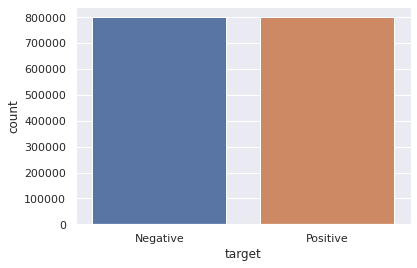

In [8]:
sns.set_theme(style="darkgrid")
sns.countplot(data=s_df,x='target')
plt.xticks(ticks=[0,1],labels=['Negative','Positive'])
plt.show()

# Hyper parameters

In [9]:
# DATASET
TEST_SIZE = 0.2

## HYPERPARAMETERS
# WORD2VEC 
W2V_SIZE = 22
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 100
EPOCHS = 5
BATCH_SIZE = 1024

# Text Preprocessing

In [10]:
X_train , X_test , y_train , y_test = train_test_split(s_df.text,s_df.target,test_size=TEST_SIZE,random_state=42)
print("TRAIN size:", len(X_train))
print("TEST size:", len(y_test))

TRAIN size: 1280000
TEST size: 320000


In [11]:
X_train.head(10)

1374558    @jbtaylor WIth ya. &quot;I'd like a Palm Pre, ...
1389115    felt the earthquake this afternoon, it seems t...
1137831          Ruffles on shirts are like so in, me Likey 
790714     Pretty bad night into a crappy morning....FML!...
1117911               @dcbriccetti yeah, what a clear view! 
1077663    One more time Follow my fam #FF @georgeann13 @...
1253991    @MsJBell U rock!!! Thanks.  Will be added to n...
1535242    @ssnider yes please! met your fiancee at ian's...
1396460    My gawd! They've finished the whole bowl befor...
1178954    @marty_k awesome game. but very short. you'll ...
Name: text, dtype: object

In [12]:
# dictionary containing all emojis.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused',
          '$_$': 'greedy','@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused','<(-_-)>': 'robot', 'd[-_-]b': 'dj', 
          ":'-)": 'sadsmile',';)': 'wink',';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}
# list containing all stopwords.
stopword =  ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an','and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do','does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here','hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma','me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them','themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was', 'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre","youve", 'your', 'yours', 'yourself', 'yourselves']

In [13]:
def preprocess(text , wordLemm):
    processedText = []
    
    for tweet in text:
        #lowercase the tweets
        tweet = tweet.lower()
        
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        
        # Replace URLs with a space in the message
        tweet = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', tweet)
        
        # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
        tweet= re.sub('\$[a-zA-Z0-9]*', ' ', tweet)
        
        # Replace usernames with a space. The usernames are any word that starts with @.
        tweet = re.sub('\@[a-zA-Z0-9]*', ' ', tweet)

        # Replace everything not a letter or apostrophe with a space
        tweet = re.sub('[^a-zA-Z\']', ' ', tweet)

        # Remove single letter words
        tweet = ' '.join( [w for w in tweet.split() if len(w)>1] )
        ######################################
        tweetwords = ''
        for word in tweet.split():
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

### lemmatization

In [14]:
wordLemm = WordNetLemmatizer()
X_train_corpus = preprocess(list(X_train),wordLemm)

In [15]:
X_train_corpus[:10]

["with ya quot i'd like palm pre touchstone charger readynow yes that sound good but is my beer ready now prelaunch ",
 'felt the earthquake this afternoon it seems to be but at the epicenter ',
 'ruffle on shirt are like so in me likey ',
 'pretty bad night into crappy morning fml if only buttface didnt say he could go into work today ',
 'yeah what clear view ',
 'one more time follow my fam ff elle welcome to friday follow me ',
 'rock thanks will be added to next robcrotch tm video ',
 "yes please met your fiancee at ian's party the other day btw she's very sweet congrats to you guy ",
 "my gawd they've finished the whole bowl before even posted my previous tweet making nd bowl ",
 "awesome game but very short you'll finish it and be craving for more god of war action "]

### Vectorizaton

#### TF-IDF

In [16]:
vect = TfidfVectorizer(ngram_range=(1,2), max_features=1000000,stop_words=stopword)
vect.fit(X_train_corpus)

TfidfVectorizer(max_features=1000000, ngram_range=(1, 2),
                stop_words=['a', 'about', 'above', 'after', 'again', 'ain',
                            'all', 'am', 'an', 'and', 'any', 'are', 'as', 'at',
                            'be', 'because', 'been', 'before', 'being', 'below',
                            'between', 'both', 'by', 'can', 'd', 'did', 'do',
                            'does', 'doing', 'down', ...])

In [17]:
tfidf_vec_X_train = vect.transform(X_train_corpus)
tfidf_vec_X_test = vect.transform(X_test)

#### Word2Vec

In [ ]:
X_train_corpus[:10]

In [ ]:
documents = [text.split() for text in X_train_corpus] 

In [ ]:
documents[0]

In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [ ]:
w2v_model.build_vocab(documents)

In [ ]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

In [ ]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

In [ ]:
w2v_model.most_similar("business")

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_corpus)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

In [ ]:
X_train_seq = tokenizer.texts_to_sequences(X_train_corpus)
X_test_seq = tokenizer.texts_to_sequences(X_test)


In [ ]:
X_train_padseq = pad_sequences(X_train_seq, maxlen=SEQUENCE_LENGTH)
X_test_padseq = pad_sequences(X_test_seq, maxlen=SEQUENCE_LENGTH)

encoder = LabelEncoder()
encoder.fit(X_train.target.tolist())

y_train_encoded = encoder.transform(X_train.target.tolist())
y_test_encoded = encoder.transform(X_test.target.tolist())

y_train_encoded = np.expand_dims(y_train_encoded, -1)
y_test_encoded = np.expand_dims(y_test_encoded, -1)

#### Embedding Layer

In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

# Creation and Training of Model

### Logistic Regression

In [18]:
log_clf = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
log_clf.fit(tfidf_vec_X_train,y_train)

log_pred = log_clf.predict(tfidf_vec_X_test)
print('Logistic Regression Accuracy :',accuracy_score(y_test,log_pred))
log_pred


Logistic Regression Accuracy : 0.8002125


array([0, 4, 4, ..., 4, 0, 0])

### Naive Bayes

In [19]:
nb_clf = MultinomialNB(alpha=0.3)
nb_clf.fit(tfidf_vec_X_train, y_train)

nb_pred = nb_clf.predict(tfidf_vec_X_test)
print('Naive Bayes Accuracy :',accuracy_score(y_test,nb_pred))

Naive Bayes Accuracy : 0.7773625


### LSTM

In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, input_length=SEQUENCE_LENGTH, trainable=False)

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.25))
model.add(Dense(1, activation="sigmoid"))

model.summary()

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=Adam(5e-4), metrics=["accuracy"])

In [ ]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [ ]:
H = model.fit(X_train_padseq, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.05, verbose=1, callbacks=callbacks)

# Prediction and Validation

[[123771  35723]
 [ 28209 132297]]


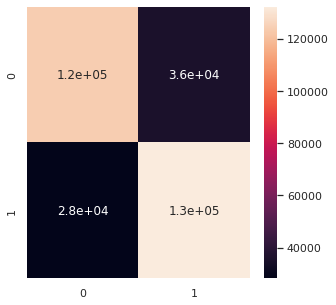

In [20]:
cm = confusion_matrix(y_test,log_pred)
print(cm)

plt.figure(figsize=(5,5))
sns.heatmap(cm,annot=True)
plt.show()

In [21]:
print(classification_report(y_test,log_pred))
print(classification_report(y_test,nb_pred))

              precision    recall  f1-score   support

           0       0.81      0.78      0.79    159494
           4       0.79      0.82      0.81    160506

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000

              precision    recall  f1-score   support

           0       0.78      0.78      0.78    159494
           4       0.78      0.78      0.78    160506

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



# Saving Model

In [22]:
filename = 'ts_model.pkl'
pickle.dump(log_clf, open(filename, 'wb'))
pickle.dump(vect, open('vectorize-transform.pkl', 'wb'))

In [23]:
from numpy.lib.function_base import vectorize
classifier = pickle.load(open(filename, 'rb'))
vectorizer = pickle.load(open('vectorize-transform.pkl','rb'))

In [25]:
data=["blaa bla good great","hell yeah!","you are killing it! keep it up"]
#vect.fit(data)
#input=vect.fit_transform(data)
input = vectorizer.transform(data).toarray()
my_pred=classifier.predict(input)
sentiments=[]
for x in my_pred:
  if x==4:
    sentiments.append("Positive")
  else:
    sentiments.append("Negative")  

print(sentiments)    

['Positive', 'Positive', 'Negative']
